## DATA PREPROCESSING SIIM-COVID19-DETECTION

Data Preprocessing for SIIM-COVID19-DETECTION DATASET. URL: https://www.kaggle.com/competitions/siim-covid19-detection/

The goal of this notebook is preparing the dataset to be used for implementing object-detection and multi-label classification algorithms.

## 0. Libraries and global variables:

In [72]:
!conda install gdcm -c conda-forge -y

Channels:
 - conda-forge
 - rapidsai
 - nvidia
 - defaults
 - file:///tmp/conda
Platform: linux-64

UnavailableInvalidChannel: HTTP 404 UNAVAILABLE OR INVALID for channel conda <file:///tmp/conda>

The channel is not accessible or is invalid.

You will need to adjust your conda configuration to proceed.
Use `conda config --show channels` to view your configuration's current state,
and use `conda config --show-sources` to view config file locations.

As of conda 4.3, a valid channel must contain a `noarch/repodata.json` and
associated `noarch/repodata.json.bz2` file, even if `noarch/repodata.json` is
empty. Use `conda index /tmp/conda`, or create `noarch/repodata.json`
and associated `noarch/repodata.json.bz2`.




In [73]:
import os
import math
import copy
import pydicom
import cv2
import shutil
import multiprocessing
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pydicom.pixel_data_handlers.util import apply_voi_lut
from pydicom.encaps import encapsulate
from multiprocessing import Manager
from itertools import chain
from random import randint

In [74]:
# Suppress pydicom warnings related to pixel data
warnings.filterwarnings("ignore",
                        category=UserWarning,
                        module="pydicom.pixel_data_handlers.numpy_handler")

In [75]:
# GLOBAL variables

# Paths to processed csvs.
BASE_PATH = "../input/eda-siim-covid19-detection"

TRAIN_CSV_PATH = os.path.join(BASE_PATH,"train.csv")
TEST_CSV_PATH = os.path.join(BASE_PATH,"test.csv")
BOXES_CSV_PATH = os.path.join(BASE_PATH,"train_boxes.csv")

# Resizing shape.
TARGET_SHAPE=(256, 256)
# Used for reading and processing DICOM images.
VOI_LUT=True
FIX_MONOCHROME=True

## 1. Loading data:

### 1.1 Reading csvs

In [76]:
train_boxes = pd.read_csv(BOXES_CSV_PATH)
train_boxes.head(3)

,box_label,xmin,ymin,xmax,ymax,id,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,image_path,int_label,y_label,rows,columns
0,opacity 1,789.28836,582.43035,1815.94498,2499.73327,000a312787f2_image,5776db0cec75,0,1,0,0,../input/siim-covid19-detection/train/5776db0c...,0,typical,3488,4256
1,opacity 1,2245.91208,591.20528,3340.57370,2352.75472,000a312787f2_image,5776db0cec75,0,1,0,0,../input/siim-covid19-detection/train/5776db0c...,0,typical,3488,4256
2,none 1,0.00000,0.00000,1.00000,1.00000,000c3a3f293f_image,ff0879eb20ed,1,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,3,negative,2320,2832


In [77]:
train_csv = pd.read_csv(TRAIN_CSV_PATH)
train_csv = train_csv.drop(columns=['boxes', 'label'])
train_csv.head(3)

,id,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,image_path,int_label,y_label
0,000a312787f2_image,5776db0cec75,0,1,0,0,../input/siim-covid19-detection/train/5776db0c...,0,typical
1,000c3a3f293f_image,ff0879eb20ed,1,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,3,negative
2,0012ff7358bc_image,9d514ce429a7,0,1,0,0,../input/siim-covid19-detection/train/9d514ce4...,0,typical


In [78]:
test_csv = pd.read_csv(TEST_CSV_PATH)
test_csv.head(3)

,id,image_path
0,a29c5a68b07b_image,../input/siim-covid19-detection/test/2fb11712b...
1,9850b5470fd6_image,../input/siim-covid19-detection/test/19c66935e...
2,8d6dea06a032_image,../input/siim-covid19-detection/test/2fc50bf19...


These are a custom CSVs generated from extractable information in SIIM-COVID19-DETECTION Dataset, and have been produced in the following notebook: https://www.kaggle.com/code/martacoll/eda-siim-covid19-detection/notebook

### 1.2 Utility functions for reading or visualizing images

In [79]:
def read_dicom_image(filename, dicom_data=False):
    """Credit: https://github.com/pydicom/pydicom/issues/319
               https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
               
    Function reads and corrects dicom pixel data to prevent x-rays from looking inverted.
    args:
        filename: DICOM file path (str)
    returns:
         modified_image_data: Image data. (pixel array)
    """
    dicom_header = pydicom.dcmread(filename) 

    #====== DICOM IMAGE DATA ======
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if VOI_LUT:
        data = apply_voi_lut(dicom_header.pixel_array, dicom_header)
    else:
        data = dicom_header.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if FIX_MONOCHROME and dicom_header.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    modified_image_data = (data * 255).astype(np.uint8)
    
    if dicom_data:
        return modified_image_data, dicom_header

    return modified_image_data

In [80]:
def plot_DICOM(images_paths, boxes=None, title=None,
               images_titles=None, resize=False, resize_shape=(2000,2000), kar=False, thickness=5):
    """
    Function to plot a variable number of DICOM images.
    args:
        images_paths: list of image paths. (list of strings)
        boxes: List of bounding boxes for each image (list of lists of floats)
        title: String for figure title. (str)
        images_titles: List of strings for image titles. (list of strings)
        resize: If true applies resize to image. (bool)
        resize_shape: Resize shape. (tuple)
        kar: If true keeps aspect ratio when resizing. (bool)
    """

    num_images = len(images_paths)
    
    cols = int(math.ceil(math.sqrt(num_images)))
    rows = int(math.ceil(num_images / cols))
    
    fig = plt.figure(figsize=(9, 8))
    gs = gridspec.GridSpec(rows, cols,
                           width_ratios=[1] * cols,
                           height_ratios=[1] * rows)
    
    for i, image_path in enumerate(images_paths):
        assert image_path.endswith(('.png', '.dcm')), "Invalid image_path values found"

        if image_path.endswith('.dcm'):
            image_data = read_dicom_image(image_path)
            image_data = np.stack([image_data, image_data, image_data],
                                  axis=-1) # To RGB.
        elif image_path.endswith('.png'):
            image_data = cv2.imread(image_path)

        # Plot bounding boxes if provided.
        if boxes is not None:
            if not boxes[i]:
                print(f'There is no ROI present in image {i + 1}.')
            elif len(boxes[i])%4!=0:
                print(f'Boxes provided have wrong format for image {i + 1}.')
            else:
                for n_box in range(0, int(len(boxes[i])/4)):
                    color = [randint(0, 255), randint(0, 255), randint(0, 255)]

                    x = int(boxes[i][0 + n_box*4])
                    y = int(boxes[i][1 + n_box*4])
                    w = int(boxes[i][2 + n_box*4])
                    h = int(boxes[i][3 + n_box*4])
                    
                    image_data = cv2.rectangle(image_data,
                                               (x, y),
                                               (w, h),
                                               color=color,
                                               thickness=thickness)
        if resize:
            image_data = resize_image(image_data, resize_shape, kar)

        ax = plt.subplot(gs[i])
        ax.grid(False)
        ax.imshow(image_data)

        if images_titles is not None:
            ax.set_title(images_titles[i])
        else:
            ax.set_title(f'Image {i + 1}')

    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

## 2. Data clean-up

From the [EDA](https://www.kaggle.com/code/martacoll/eda-siim-covid19-detection) performed, we observed that study label 'Negative for pneumonia' have no bounding boxes asociated. For the rest of study labels, a minor percentage of images had no bounding box. For ensuring that future analysis predict a bounding box for these classes, images with no bounding box for these categories will be deleted.

In [81]:
# Cleanup.
no_bbx = train_boxes.loc[(train_boxes.box_label == 'none 1') &
                         (train_boxes.y_label != 'negative')]
no_bbx_ids = no_bbx.id.unique()
train_csv = train_csv[~train_csv.id.isin(no_bbx_ids)].reset_index(drop = True)
train_boxes = train_boxes[~train_boxes.id.isin(no_bbx_ids)].reset_index(drop = True)

## 2. Data Augmentation

From the [EDA](https://www.kaggle.com/code/martacoll/eda-siim-covid19-detection) performed, we have seen a need of balancing the target variable distribution. To achieve it, data augmentation will be applied for minoritary categories.

When augmenting data for X-ray images, it's important to consider the medical context and the specific characteristics of X-ray imaging. Recommended data augmentation techniques for X-ray images:

**Rotation:**
Rotate the X-ray images by small angles to simulate different perspectives. This can help the model become more robust to variations in positioning during imaging.

**Flip (Horizontal and Vertical):**
Horizontal and vertical flips can be applied to simulate X-ray images taken from different orientations, enhancing the model's ability to generalize.

**Translation:**
Shifting the X-ray images horizontally or vertically can simulate slight changes in the patient's position or the X-ray machine's alignment.

**Brightness and Contrast Adjustments:**
Modifying the brightness and contrast of X-ray images can simulate variations in imaging conditions. Care should be taken to ensure that the adjustments do not compromise the diagnostic quality.


**Noise Injection:**
Add different types of noise (e.g., Gaussian noise) to the X-ray images to make the model more robust to noisy data.

**Blur:**
Apply slight blurring to simulate the inherent blurriness that might be present in X-ray images due to factors like motion or equipment limitations.

**Cropping:**
Randomly crop X-ray images to focus on specific regions of interest. This can help the model learn to detect features in different parts of the image.

**Gamma Correction:**
Adjust the gamma of the X-ray images to simulate variations in the intensity of the X-ray radiation.

It's crucial to note that any data augmentation applied to medical images should be done cautiously, with consideration for patient safety and the potential impact on diagnostic accuracy. Additionally, it's often beneficial to consult with medical professionals to ensure that the augmented data remains clinically relevant.

### 2.1 Study of different data augmentation strategies

In [82]:
def rotate_image(image, angle):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return "Rotation", cv2.warpAffine(image, M, (cols, rows))

def flip_image(image, flip_code):
    assert flip_code in [0, 1, -1], "Wrong flip code, options are 0, 1, -1"
    if flip_code == 1:
        flip_type = "Horizontal flip"
    elif flip_code == 0:
        flip_type = "Vertical flip"
    else:
        flip_type = "Horizontal and vertical flip"

    return f"{flip_type}", cv2.flip(image, flip_code)

def translate_image(image, tx, ty): # Img size is the same after translation. Interpolates.
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return "Translation", cv2.warpAffine(image, M, (cols, rows))

def adjust_brightness_contrast(image, alpha, beta):
    return "Brightness and Contrast Adjustments", cv2.convertScaleAbs(image,
                                                                      alpha=alpha,
                                                                      beta=beta)

def add_noise(image, mean=0, sigma=25):
    row, col = image.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = np.clip(image + gauss, 0, 255)
    return "Noise Injection", noisy.astype(np.uint8)


def apply_blur(image, kernel_size=(5, 5)):
    # Ensure that the kernel size is a positive odd integer tuple
    kernel_size = (kernel_size[0] if kernel_size[0] % 2 == 1 else kernel_size[0] + 1,
                   kernel_size[1] if kernel_size[1] % 2 == 1 else kernel_size[1] + 1)
    return "Blur", cv2.GaussianBlur(image, kernel_size, 0)

def crop_image(image, crop_percent=0.2):
    height, width = image.shape[:2]
    crop_pixels = int(min(height, width) * crop_percent)
    return "Cropping", image[crop_pixels:height-crop_pixels,
                             crop_pixels:width-crop_pixels]

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)])
    return "Gamma correction", cv2.LUT(image.astype(np.uint8),
                                       table.astype(np.uint8))

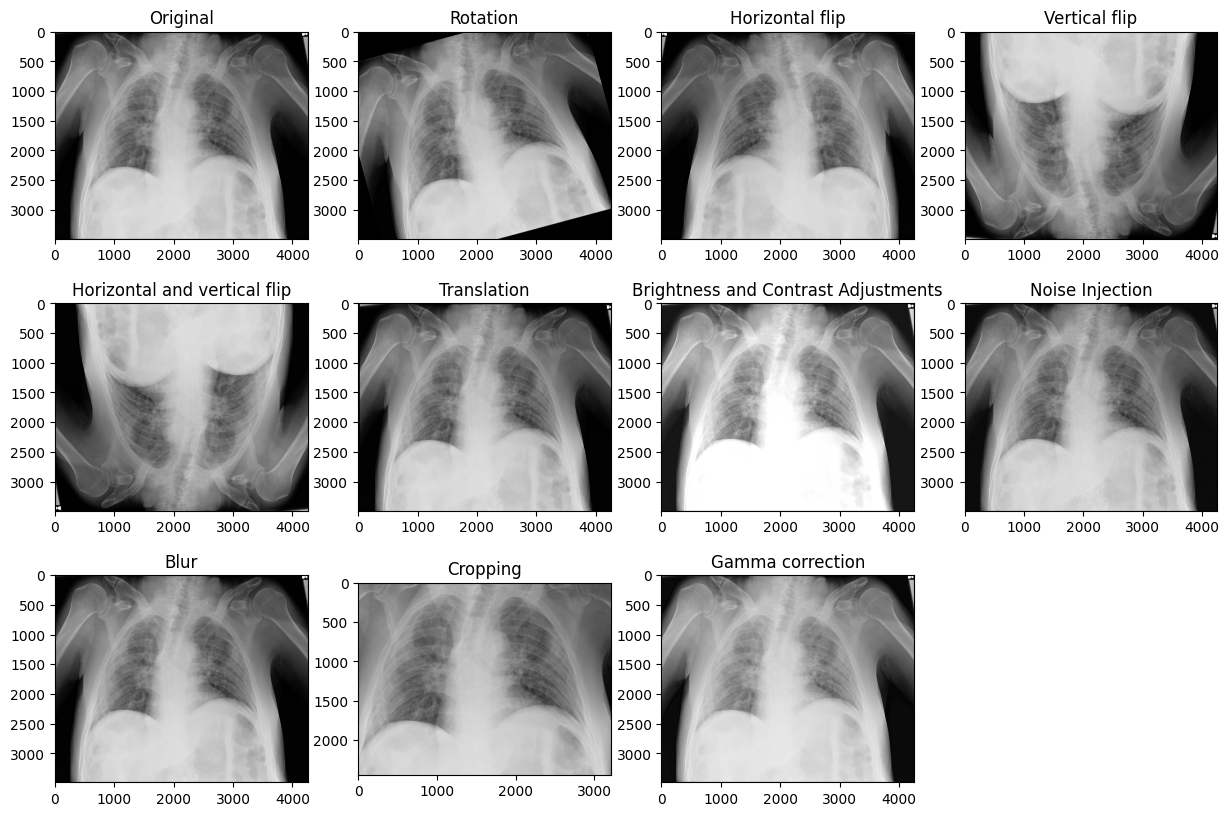

In [83]:
# Load an example X-ray image (replace 'your_image_path.jpg' with the actual path)
image_path = train_csv.image_path[0]
original_image = read_dicom_image(image_path)

fig = plt.figure(figsize=(15, 10))
# Display the original image
plt.subplot(3, 4, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original')

# Apply data augmentation techniques and display the augmented images
augmentations = [
    (rotate_image, {'angle': 15}),
    (flip_image, {'flip_code': 1}),  # 1 for horizontal flip
    (flip_image, {'flip_code': 0}),  # 0 for vertical flip
    (flip_image, {'flip_code': -1}),  # 1 for horizontal and vertical flip
    (translate_image, {'tx': 30, 'ty': 20}),
    (adjust_brightness_contrast, {'alpha': 1.2, 'beta': 20}),
    (add_noise, {'mean': 0.1, 'sigma': 25}),
    (apply_blur, {'kernel_size': (10, 10)}),
    (crop_image, {'crop_percent': 0.15}),
    (adjust_gamma, {'gamma': 1.5})
]

for i, (augmentation, kwargs) in enumerate(augmentations, start=2):
    title, augmented_image = augmentation(original_image, **kwargs)
    plt.subplot(3, 4, i)
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    plt.title(f'{title}')

plt.show()

From different strategies analyzed, strateggies that imply a position shift will be selected for data augmentation; cropping, horizontal flip and translation. With the addition of not very noticeble noise ingection and blur, to avoid losing medical relevant data. Rotation is discarded due to the complexity on recalculating the bounding boxes. 

Brightness and contrast or gamma might be modified if image enhancing is applied later so we will discard them aswell. 

The goal will be to duplicate images for 'Indeterminate' category, and triplicate images for 'Atypical'.

### 2.2 Adjust bounding boxes based on DA method used.

#### 2.2.1 Implementation

In [84]:
def recalculate_bounding_box(original_bbox, transformation, t_image_shape, o_image_shape, **kwargs):
    
    assert transformation in ["Horizontal flip",
                              "Cropping",
                              "Translation"], "Transformation not implemented."

    xmin, ymin, xmax, ymax = original_bbox
    t_height, t_width = t_image_shape[:2]
    
    if transformation == "Horizontal flip":
        new_xmin = t_width - xmax
        new_ymin = ymin
        new_xmax = t_width - xmin
        new_ymax = ymax

    elif transformation == "Cropping":
        height, width = o_image_shape[:2]
        crop_pixels = int(min(height, width) * kwargs.get("crop_percent"))
        
        # Calculate the intersection between the original box and the crop region.
        x_intersection = max(0, min(xmax, width - crop_pixels) - max(xmin, crop_pixels))
        y_intersection = max(0, min(ymax, height - crop_pixels) - max(ymin, crop_pixels))

        # If there's no intersection, create a 1px bbox 0, 0, 1, 1.
        if x_intersection == 0 or y_intersection == 0:
            new_xmin = 0
            new_ymin = 0
            new_xmax = 1
            new_ymax = 1
        else :
            # Adjust coordinates based on the crop operation.
            new_xmin = max(0, xmin - crop_pixels)
            new_ymin = max(0, ymin - crop_pixels)
            new_xmax = min(xmax - crop_pixels, t_width)
            new_ymax = min(ymax - crop_pixels, t_height)
     
    else: # Translation.
        tx = kwargs.get("tx")
        ty = kwargs.get("ty")
        # Adjust bounding box coordinates based on translation (tx, ty).
        new_xmin = min(xmin + tx, t_width)
        new_ymin = min(ymin + ty, t_height)
        new_xmax = min(xmax + tx, t_width)
        new_ymax = min(ymax + ty, t_height)
        
        # Case original bbox falls outside translated image. 
        if new_xmin == t_width or new_ymin == t_height:
            new_xmin = 0
            new_ymin = 0
            new_xmax = 1
            new_ymax = 1

    return [new_xmin, new_ymin, new_xmax, new_ymax]

In [85]:
# TODO : delete
def save_array_to_dcm(image_array, dicom_data, out_path):
    """
    Function to store a modified image_array back to file type dcm.
    """
    # Modify dicom_data fields after transformations done in image_array.
    dicom_data.PixelData = image_array.tobytes()
    dicom_data.Rows, dicom_data.Columns = image_array.shape
    dicom_data.BitsStored = 8  # Number of bits used for encoding pixel values.
    dicom_data.BitsAllocated = 8  # Number of bits allocated in the pixel data.
    dicom_data.SamplesPerPixel = 1
    dicom_data.PhotometricInterpretation = "" # Avoids MONOCHROME1 correction to be re-applied.
    try: 
        dicom_data.save_as(out_path)
    except Exception:
        return False
    else:
        return True

In [86]:
def add_image_to_csvs(original_path, img_path, img_shape, boxes):
    """
    Function adds new row to dataset dfs (csvs), with new img info.
    """
    global train_csv, train_boxes

    img_id = os.path.basename(img_path).replace(".dcm", "_image")
    # Update train_csv.
    original_img_row = train_csv.loc[train_csv.image_path == original_path]
    new_row = copy.deepcopy(original_img_row)
    new_row.image_path = img_path
    new_row.id = img_id
    train_csv = pd.concat([train_csv, new_row], ignore_index=True)
    train_csv = train_csv.drop_duplicates()

    # Update train_boxes.
    original_img_row = train_boxes.loc[train_boxes.image_path == original_path].head(1)
    new_row = copy.deepcopy(original_img_row)
    new_row.image_path = img_path
    new_row.id = img_id
    new_row['rows'] = img_shape[0]
    new_row['columns'] = img_shape[1]
    for box in boxes:
        new_row.xmin = box[0]
        new_row.ymin = box[1]
        new_row.xmax = box[2]
        new_row.ymax = box[3]
        train_boxes = pd.concat([train_boxes, new_row], ignore_index=True)
    train_boxes = train_boxes.drop_duplicates()

In [87]:
def apply_da_techniques(img_ids, transformations, update=True):
    """
    Functions apply DA techniques listed in transformations to 'train' images, to
    produce new images from them.
    Note: Function wont save produced images with 'negative' label since they have no bboxes
    and are not relevant for future tasks.
    """
    global train_boxes
    da_base_path = "/kaggle/working/tmp/da"
    os.makedirs(da_base_path, exist_ok=True)

    boxes = []
    paths = []
    # Obtain original image paths and boxes.
    for im_id in img_ids:
        slice_boxes = train_boxes.loc[train_boxes['id'] == im_id]
        # This df can have more than one row with same id.
        path = slice_boxes['image_path'].iloc[0] 
        img_boxes = [[row['xmin'], row['ymin'], row['xmax'], row['ymax']]
                     if row['y_label'] != 'negative' else []
                     for _,row in slice_boxes.iterrows()]
        boxes.append(img_boxes)
        paths.append(path)
    
    original_boxes = copy.deepcopy(boxes)
    new_paths = []
    new_boxes = []
    
    # Apply transformations to original image and store it.
    for i, path in enumerate(paths):
        im_boxes = [] # Initializing here for case where boxes need no transformation.
        out_file_prefix = "da_"
        
        original_image, dicom_data = read_dicom_image(path, dicom_data=True)
        o_im_shape = original_image.shape
        da_image = original_image # Allows to acomulate transformations. 

        for _, (transformation, kwargs) in enumerate(transformations, start=2):
            # Create new image from transforming the original.
            title, da_image = transformation(da_image, **kwargs)
            t_im_shape = da_image.shape
            # Recalculate bboxes if needed:
            if title in ["Cropping", "Horizontal flip", "Translation"]:
                im_boxes = []
                for box in boxes[i]:
                    if not box: # Case label box == none
                        new_box = []
                    else:
                        new_box = recalculate_bounding_box(box,
                                                           title,
                                                           t_im_shape,
                                                           o_im_shape,
                                                           **kwargs)
                    if new_box != [0, 0, 1, 1] and new_box:
                        im_boxes.append(new_box)
                    
                boxes[i] = im_boxes # Ensures multiple transformations can be applied.
            out_file_prefix+= title.lower().replace(" ", "_") + "_" # Add transformation to out filename prefix.
        
        new_boxes.append(im_boxes) # Appends transformed boxes for image.
        
        if im_boxes:
            # Save new image if there are boxes in it or if test=True. 
            new_path = (os.path
                        .join(da_base_path, out_file_prefix + os.path.basename(path))
                        .replace('dcm', 'png'))
            # Saving processed image.
            cv2.imwrite(new_path,
                da_image)
            new_paths.append(new_path)
            if update:
                add_image_to_csvs(path, new_path, t_im_shape, im_boxes)
    
    return paths, new_paths, original_boxes, new_boxes

#### 2.2.2 Visual check

In [88]:
# Id's of images to modify.
img_ids = train_csv['id'][8:12].tolist()

In [89]:
# Transformations to apply to each image.
transformations = [
    (flip_image, {'flip_code': 1}),  # 1 for horizontal flip
    (add_noise, {'mean': 0.1, 'sigma': 25}),
    (apply_blur, {'kernel_size': (10, 10)})
]

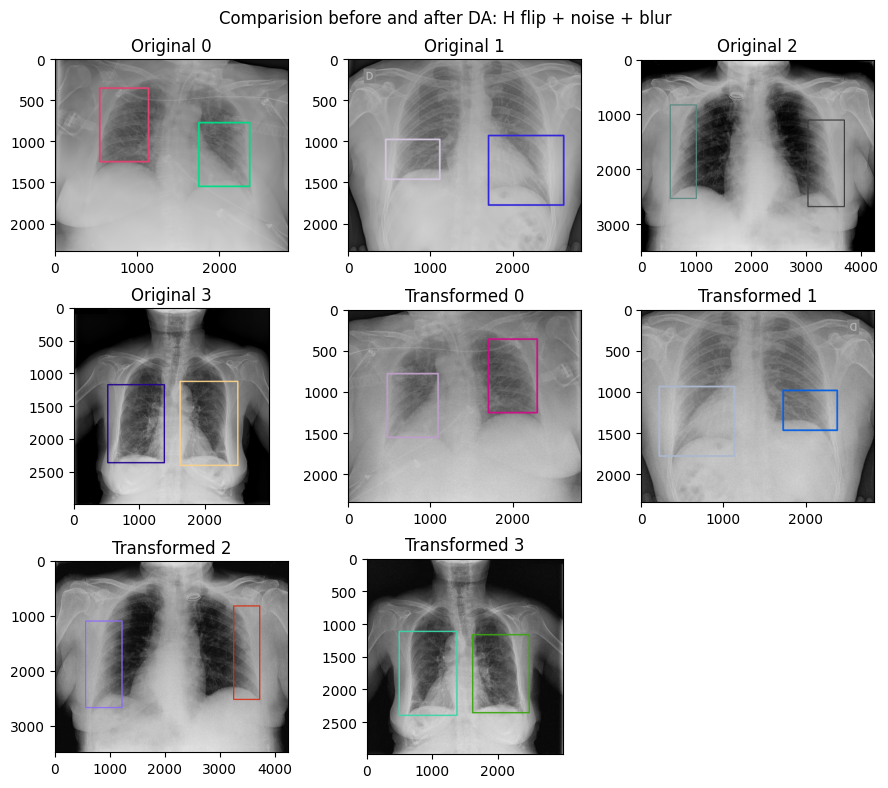

In [90]:
paths, new_paths, boxes, new_boxes = apply_da_techniques(img_ids, transformations, update=False)

paths_to_plot = paths + new_paths
boxes_to_plot = [list(chain.from_iterable(img_boxes))
                      for img_boxes in boxes + new_boxes]
images_titles = [f"Original {i}" if i < len(paths)
                 else f"Transformed {i-len(paths)}"
                 for i in range(len(paths_to_plot))]

plot_DICOM(paths_to_plot,
           boxes=boxes_to_plot,
           title='Comparision before and after DA: H flip + noise + blur',
           images_titles=images_titles,
           thickness=20)

In [91]:
transformations = [
    (translate_image, {'tx': 1800, 'ty': 20}),
    (add_noise, {'mean': 0.1, 'sigma': 25}),
    (apply_blur, {'kernel_size': (10, 10)})
]

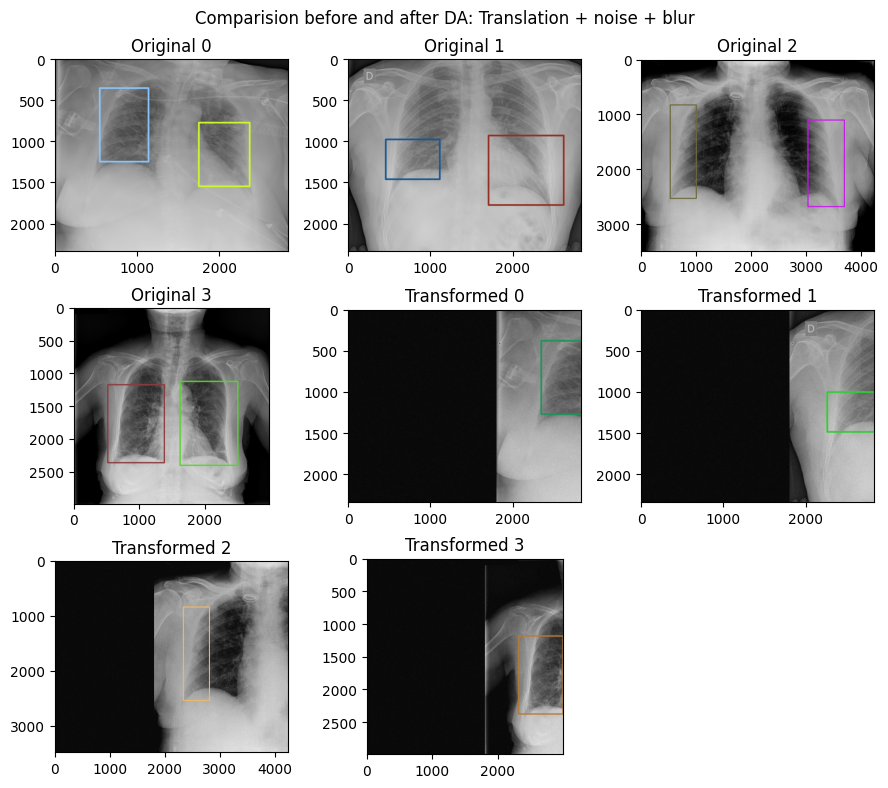

In [92]:
paths, new_paths, boxes, new_boxes = apply_da_techniques(img_ids, transformations, update=False)

paths_to_plot = paths + new_paths
boxes_to_plot = [list(chain.from_iterable(img_boxes))
                      for img_boxes in boxes + new_boxes]
images_titles = [f"Original {i}" if i < len(paths)
                 else f"Transformed {i-len(paths)}"
                 for i in range(len(paths_to_plot))]

plot_DICOM(paths_to_plot,
           boxes=boxes_to_plot,
           title='Comparision before and after DA: Translation + noise + blur',
           images_titles=images_titles,
           thickness=20)

In [93]:
transformations = [
    (crop_image, {'crop_percent': 0.25}),
    (add_noise, {'mean': 0.1, 'sigma': 25}),
    (apply_blur, {'kernel_size': (10, 10)})
]

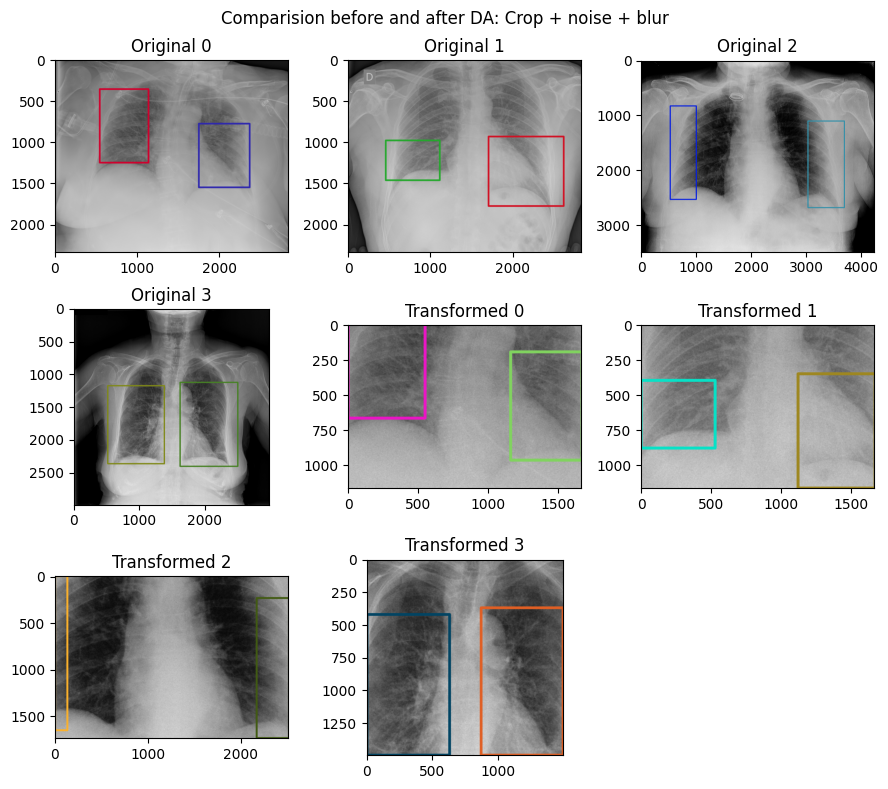

In [94]:
paths, new_paths, boxes, new_boxes = apply_da_techniques(img_ids, transformations, update=False)

paths_to_plot = paths + new_paths
boxes_to_plot = [list(chain.from_iterable(img_boxes))
                      for img_boxes in boxes + new_boxes]
images_titles = [f"Original {i}" if i < len(paths)
                 else f"Transformed {i-len(paths)}"
                 for i in range(len(paths_to_plot))]

plot_DICOM(paths_to_plot,
           boxes=boxes_to_plot,
           title='Comparision before and after DA: Crop + noise + blur',
           images_titles=images_titles,
           thickness=20)

In [95]:
directory_to_delete = "/kaggle/working/tmp/da"
try:
    shutil.rmtree(directory_to_delete)
    print(f"Directory '{directory_to_delete}' and its contents successfully removed.")
except OSError as e:
    print(f"Error: {e}")

Directory '/kaggle/working/tmp/da' and its contents successfully removed.


#### 2.2.3 Apply DA strategy

Now DA techniques will be applied to try to even out the target variable categories. Reaching aproximatelly 2k amount for atypical, indeterminate and typical classes.

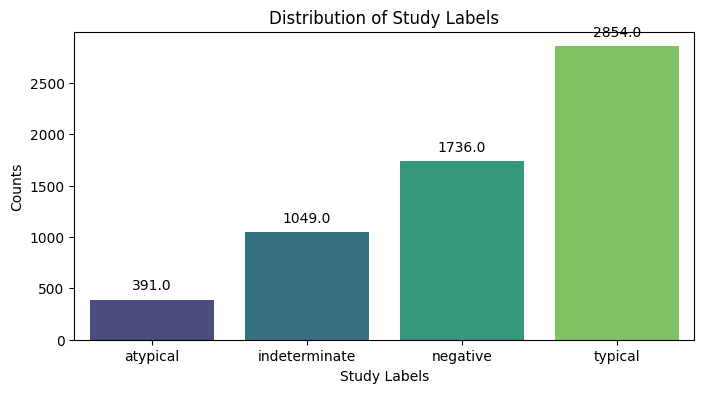

In [96]:
# Create a new DataFrame with counts aggregated by 'y_label'.
agg_df = train_csv.groupby('y_label').size().reset_index(name='count')

# Create a bar plot.
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='y_label',
                 y='count',
                 data=agg_df,
                 palette='viridis')

# Add annotations with counts.
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title.
plt.xlabel('Study Labels')
plt.ylabel('Counts')
plt.title('Distribution of Study Labels')

# Show the plot
plt.show()

**Atypical:**

In [97]:
# Id's of images to modify.
img_ids = train_csv.loc[train_csv.y_label == 'atypical']['id'].tolist()

In [98]:
# Transformations to apply.
transformations_set_1 = [
    (crop_image, {'crop_percent': 0.15}),
    (add_noise, {'mean': 0, 'sigma': 20}),
    (apply_blur, {'kernel_size': (3, 3)})
]

transformations_set_2 = [
    (translate_image, {'tx': 50, 'ty': 50}),
    (add_noise, {'mean': 0, 'sigma': 20}),
    (apply_blur, {'kernel_size': (3, 3)})
]

transformations_set_3 =  [
    (flip_image, {'flip_code': 1}),  # 1 for horizontal flip
    (add_noise, {'mean': 0, 'sigma': 15}),
    (apply_blur, {'kernel_size': (5, 5)})
]

In [99]:
_ = apply_da_techniques(img_ids, transformations_set_1)
_ = apply_da_techniques(img_ids, transformations_set_2)
_ = apply_da_techniques(img_ids, transformations_set_3)

**Indeterminate:**

In [100]:
# Id's of images to modify.
img_ids = train_csv.loc[train_csv.y_label == 'indeterminate']['id'].tolist()

In [101]:
transformations_set_3 =  [
    (flip_image, {'flip_code': 1}),  # 1 for horizontal flip
    (add_noise, {'mean': 0, 'sigma': 15}),
    (apply_blur, {'kernel_size': (5, 5)})
]

In [102]:
_ = apply_da_techniques(img_ids, transformations_set_3)

**Typical**:

In [103]:
# Random selection of rows.
sample = train_csv[train_csv.y_label == 'typical'].sample(n=800)

# Drop the selected rows from the DataFrame.
train_csv = train_csv[~train_csv.id.isin(sample.id.to_list())]

# Delete rows with id in sample.
train_boxes = train_boxes[~train_boxes.id.isin(sample.id.to_list())]    

Resulting distribution:

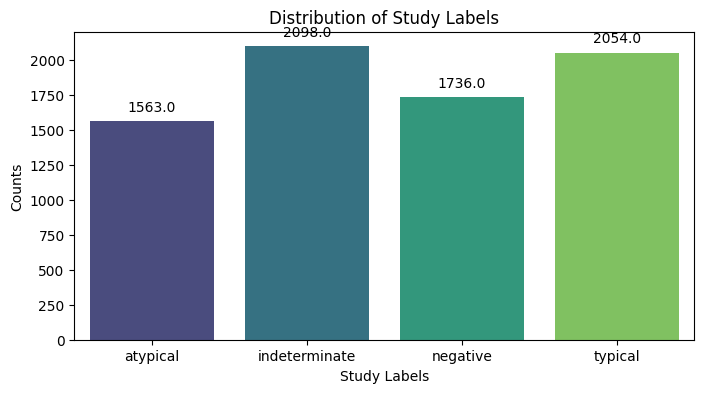

In [104]:
# Create a new DataFrame with counts aggregated by 'y_label'.
agg_df = train_csv.groupby('y_label').size().reset_index(name='count')

# Create a bar plot.
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='y_label',
                 y='count',
                 data=agg_df,
                 palette='viridis')

# Add annotations with counts.
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title.
plt.xlabel('Study Labels')
plt.ylabel('Counts')
plt.title('Distribution of Study Labels')

# Show the plot
plt.show()

## 3. Image Enhancing

- If time, data enhancing and   https://www.kaggle.com/code/rerere/covid-19-image-enhancement 


## 4. Image Resizing

### 4.1 Utility functions

In [105]:
def resize_image(image_array, target_shape, keep_aspect_ratio=False):
    """
    Function resizes the image_array to the target shape maintaining the aspect
    ratio or not depending on the value of 'keep_aspect_ratio'.
    """
    if keep_aspect_ratio:
        # Calculate the aspect ratio.
        aspect_ratio = image_array.shape[1] / image_array.shape[0]

        new_width = int(target_shape[0] * aspect_ratio)

        resized_image = cv2.resize(image_array,
                                   (new_width, target_shape[0]))
    else:
        # Resize the image without maintaining aspect ratio
        resized_image = cv2.resize(image_array,
                                   (target_shape[1], target_shape[0]))

    return resized_image

In [106]:
def scale_bbox(original_shape, resized_shape, bbox):
    """
    Function scales the bounding boxes according to the size of the resized image. 
    """
    # Get scaling factor.
    scale_x = resized_shape[1]/original_shape[1]
    scale_y = resized_shape[0]/original_shape[0]

    x = int(bbox[0]*scale_x) # xmin.
    y = int(bbox[1]*scale_y) # ymin.
    x1 = int(bbox[2]*scale_x) # xmax.
    y1= int(bbox[3]*scale_y) # ymax.
        
    return [x, y, x1, y1]

### 4.2 Examples of resizes:

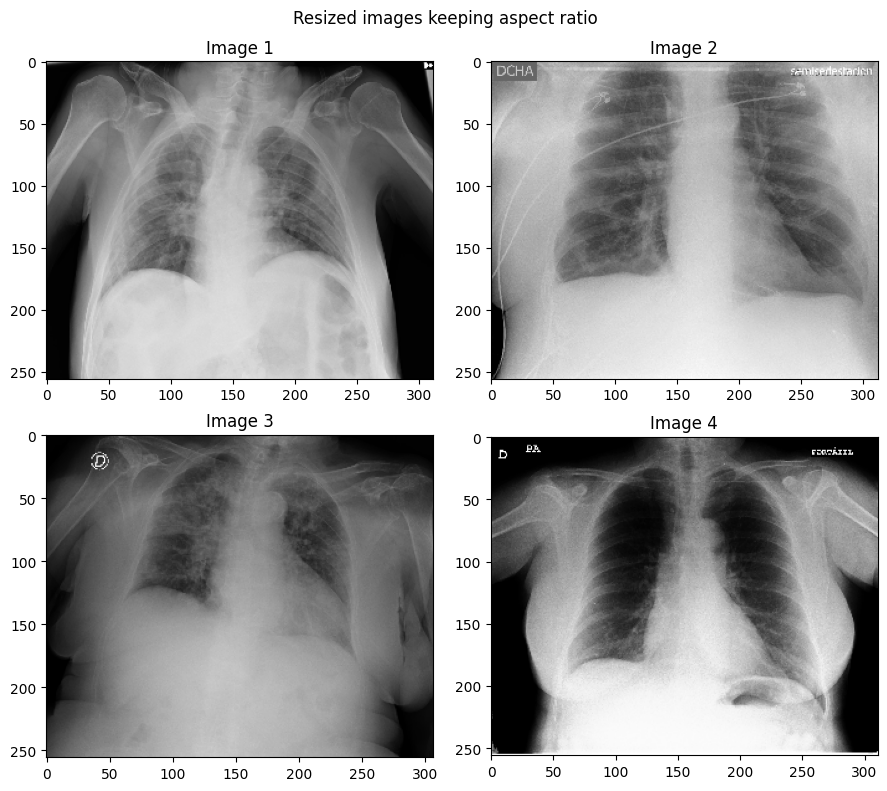

In [107]:
images_paths = train_csv["image_path"][:4].tolist()
plot_DICOM(images_paths,
           title="Resized images keeping aspect ratio",
           resize=True,
           resize_shape=TARGET_SHAPE,
           kar=True)

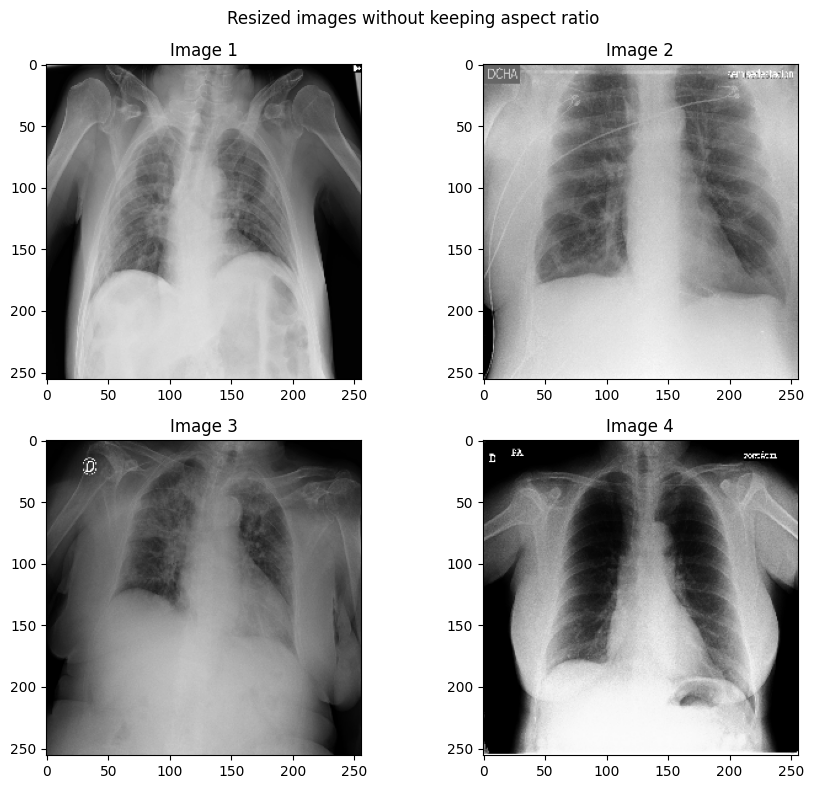

In [108]:
plot_DICOM(images_paths,
           title="Resized images without keeping aspect ratio",
           resize=True,
           resize_shape=TARGET_SHAPE,
           kar=False)

## 5 Processing the full dataset:

The dataset processing includes:

1. Resizing images and changing format to png.
2. Performing image enhancing if option is set to True.
3. Modifications in CSVs:
    - Store new shape after resizing.
    - Update image paths.
    - Recalculate new bounding boxes after resizing. 

In [109]:
def process_and_save_image(file_path, save_dir, split_info, results, enhancing, target_shape, kar):
    """
    Function processes an image and its corresponding rows, from dataset info dataframes,
    and saves processed image in png format.
    """
    def _update_rows(row, boxes=False):
        """
        Updates df row after resizing, updating also the image path.
        """
        if boxes:
            if row['box_label'].startswith('opacity'):
                bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
                row['xmin'], row['ymin'], row['xmax'], row['ymax'] = scale_bbox(original_shape,
                                                                                resized_shape, bbox)
        row['image_path'], row['rows_resized'], row['columns_resized'] = [f'{split_info[0]}/{filename}',
                                                                            int(resized_shape[1]),
                                                                            int(resized_shape[0])]
        return row

    filename = os.path.basename(file_path)
    
    if filename.endswith('dcm'):
        # Reading image and resizing.
        image_array = read_dicom_image(file_path)
        filename = filename.replace('dcm', 'png') # Filname after processing.
    else:
        image_array = cv2.imread(file_path)
    original_shape = list(image_array.shape)
    image_array = resize_image(image_array,
                               target_shape=target_shape,
                               keep_aspect_ratio=kar)
    resized_shape = list(image_array.shape)

    if enhancing:
        pass # Add it if there is time.
    
    # Changing image_path from dataframes and adding new im shape.
    slice_df = split_info[1][split_info[1]['image_path'] == file_path]
    rows_to_update = slice_df.copy()
    rows_to_update = rows_to_update.apply(_update_rows, axis=1)
    
    # Adding modifications to the manager.
    results[0].append(rows_to_update.to_dict(orient='records'))
    
    # Process train_boxes.csv.
    if split_info[0] == 'train':
        # Locating rows for processed image.  
        slice_df = split_info[2][split_info[2]['image_path'] == file_path]

        rows_to_update = slice_df.copy()
        rows_to_update = rows_to_update.apply(_update_rows, axis=1, boxes=True)
        # Adding modifications to the manager.
        results[1].append(rows_to_update.to_dict(orient='records'))
   
    # Saving processed image.
    cv2.imwrite(os.path.join(save_dir, filename),
                image_array)

In [110]:
def process_split(split_info, enhancing=False, target_shape=(256,256), kar=False):
    """
    Using multi processing, function processes the images asociated with a given split.
    Updates provided split_info dataframes after the processing and stores them in a csv.
    args:
        split_info: List where first element is the name of the split (str), second
                    element is a copy of the corresponding split df (df), and if the split
                    is the 'train' split, there will be a third item for a copy of the
                    train_boxes df (df).
        enhancing: If true, image processing to improve image quality is applied. (bool)
        target_shape: Target shape for the resizing (cols, rows) format. (tuple)
        kar: If true keeps the aspect ratio for images when resizing (image shapes might vary
             depending on the image). Default is false and it producs a square image. (bool)
    """

    save_dir = f'/kaggle/working/tmp/{split_info[0]}/'
    os.makedirs(save_dir, exist_ok=True)
    
    # Create new columns in df for resized shape.
    split_info[1]['rows_resized'] = None
    split_info[1]['columns_resized'] = None
    split_info[1] = split_info[1].reset_index()
    
    if len(split_info)==3:
        split_info[2]['rows_resized'] = None
        split_info[2]['columns_resized'] = None
        split_info[2] = split_info[2].reset_index()

    with Manager() as manager:
        # Dict to store the dataframes modifications in each process.
        results = [manager.list(), manager.list()]
    
        with multiprocessing.Pool() as pool:
            jobs = []
            for file_path in split_info[1]['image_path']:
                job = pool.apply_async(process_and_save_image,
                                       args=(file_path,
                                             save_dir,
                                             split_info,
                                             results,
                                             enhancing,
                                             target_shape,
                                             kar))
                jobs.append(job)
            
            # Wait for all processes to finish
            for job in jobs:
                job.get()

        # Combine the results from each process.
        updated_rows = pd.DataFrame([v for sublist in results[0] for v in sublist])
        updated_rows_boxes = pd.DataFrame([v for sublist in results[1] for v in sublist])

        if not updated_rows.empty:
            
            # Update original df.
            columns_to_update = updated_rows.columns.difference(['index'])
            split_info[1].loc[split_info[1]['index'].isin(updated_rows['index']),
                              columns_to_update] = updated_rows[columns_to_update].values
            split_info[1] = split_info[1].drop('index', axis=1, errors='ignore')

        # Save split info csv with modifications.
        split_info[1].to_csv(f'/kaggle/working/{split_info[0]}_p.csv',
                            index=False)

        # Concatenate all the updated rows
        if not updated_rows_boxes.empty:
            # Update the original DataFrame.
            columns_to_update = updated_rows_boxes.columns.difference(['index'])
            split_info[2].loc[split_info[2]['index'].isin(updated_rows_boxes['index']),
                              columns_to_update] = updated_rows_boxes[columns_to_update].values
            split_info[2] = split_info[2].drop('index', axis=1, errors='ignore')

            # Save train_boxes csv with modifiecations.
            split_info[2].to_csv(f'/kaggle/working/{split_info[0]}_boxes_p.csv',
                                 index=False)    

In [111]:
splits = [['train', train_csv.copy(),
           train_boxes.copy()],
          ['test', test_csv.copy()]]


for split in splits:
    process_split(split, TARGET_SHAPE)

In [119]:
%%time
!tar -zcf train.tar.gz -C "/kaggle/working/tmp/train/" .
!tar -zcf test.tar.gz -C "/kaggle/working/tmp/test/" .

CPU times: user 562 ms, sys: 86.9 ms, total: 649 ms
Wall time: 25.8 s


### 5.1 Image comparison before and after processing.

In [113]:
img_ids = train_csv['id'][:4].tolist()

#### 5.1.1 Images before processing

In [114]:
boxes = []
for im_id in img_ids:
    slice_boxes = train_boxes.loc[train_boxes['id'] == im_id]
    img_boxes = [[row['xmin'], row['ymin'], row['xmax'], row['ymax']]
                 for _,row in slice_boxes.iterrows()] 
    boxes.append(list(chain.from_iterable(img_boxes))) # Reformat for plotting.

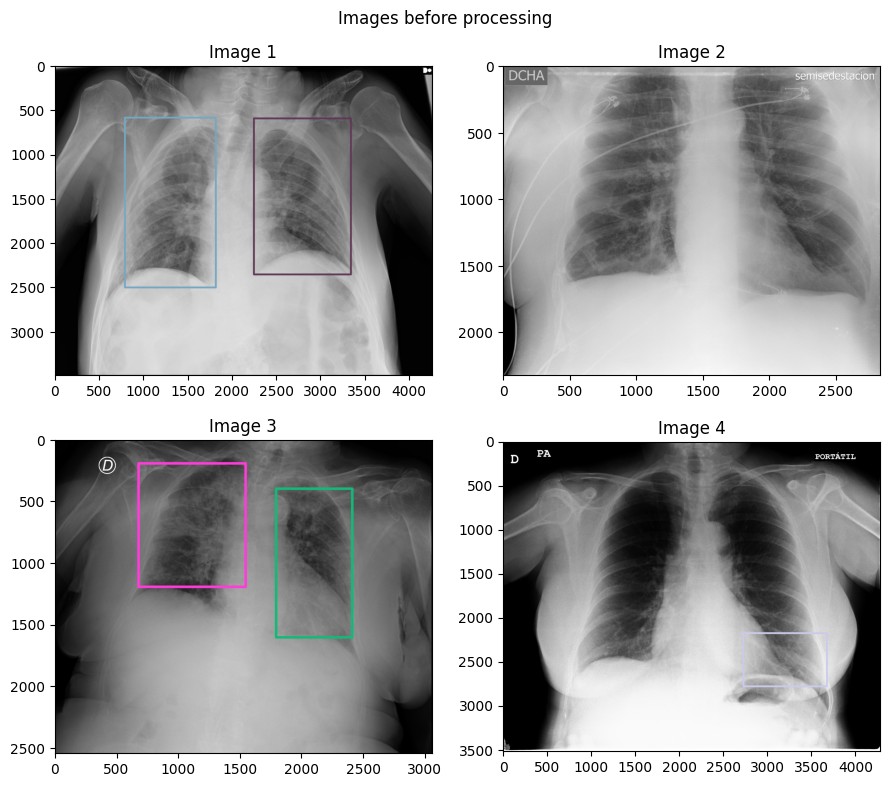

In [115]:
plot_DICOM(train_csv['image_path'][:4],
           boxes=boxes,
           title='Images before processing',
           thickness=20)

#### 5.1.2 Images after processing

In [116]:
train_csv_p = pd.read_csv("/kaggle/working/train_p.csv")
train_boxes_p = pd.read_csv("/kaggle/working/train_boxes_p.csv")

In [117]:
boxes = []
paths = []
for im_id in img_ids:
    slice_boxes = train_boxes_p.loc[train_boxes_p['id'] == im_id]
    path = os.path.join("/kaggle/working/tmp", slice_boxes['image_path'].iloc[0])
    img_boxes = [[row['xmin'], row['ymin'], row['xmax'], row['ymax']]
                 for _,row in slice_boxes.iterrows()]
    boxes.append(list(chain.from_iterable(img_boxes))) # Reformat for plotting.
    paths.append(path)

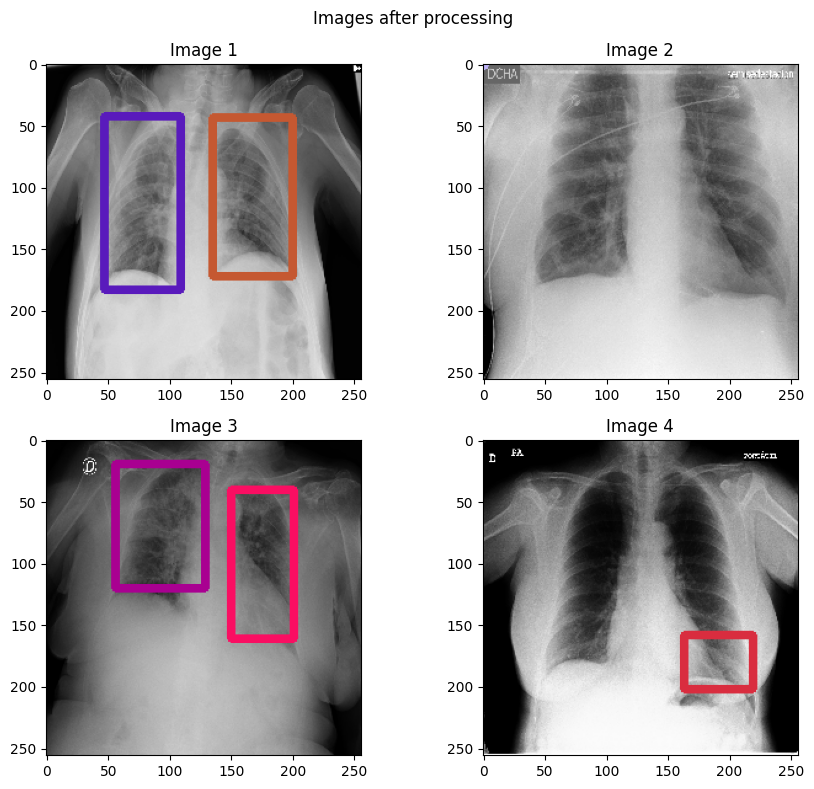

In [118]:
plot_DICOM(paths,
           boxes=boxes,
           title='Images after processing')

In [120]:
directory_to_delete = "/kaggle/working/tmp"
try:
    shutil.rmtree(directory_to_delete)
    print(f"Directory '{directory_to_delete}' and its contents successfully removed.")
except OSError as e:
    print(f"Error: {e}")


Directory '/kaggle/working/tmp' and its contents successfully removed.
